In [1]:
using BenchmarkTools
using Plots; pyplot()

Plots.PyPlotBackend()

# Divide-and-conquer matrix multiplication

In [2]:
function divide_and_conquer(A, B)
    
    n = size(A)[1]
    
    if n == 1
        return A*B
    end
    
    n2 = Int(n/2)
    
    prod = zeros(n, n)
    
    prod[1:n2,     1:n2]     = A[1:n2,     1:n2]*B[1:n2, 1:n2]     + A[1:n2,     n2+1:end]*B[n2+1:end, 1:n2]
    prod[1:n2,     n2+1:end] = A[1:n2,     1:n2]*B[1:n2, n2+1:end] + A[1:n2,     n2+1:end]*B[n2+1:end, n2+1:end]
    prod[n2+1:end, 1:n2]     = A[n2+1:end, 1:n2]*B[1:n2, 1:n2]     + A[n2+1:end, n2+1:end]*B[n2+1:end, 1:n2]
    prod[n2+1:end, n2+1:end] = A[n2+1:end, 1:n2]*B[1:n2, n2+1:end] + A[n2+1:end, n2+1:end]*B[n2+1:end, n2+1:end]
    
    return prod
    
end

divide_and_conquer (generic function with 1 method)

In [3]:
ns = Int.(2 .^ range(1, 11, step=1))
time_cmm = zeros(11)
time_dcm = zeros(11)

for (i, n) in enumerate(ns)
    
    A = rand(n, n)
        
    val, time_cmm[i] = @timed A*A
    val, time_dcm[i] = @timed divide_and_conquer(A, A)
        
end

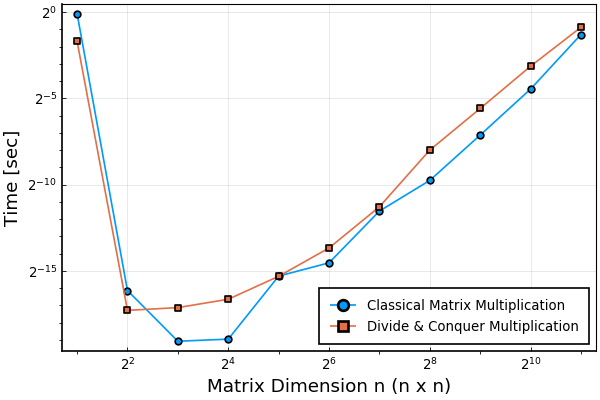

In [4]:
plot( ns, time_cmm, xscale=:log2, yscale=:log2, label="Classical Matrix Multiplication", 
        box=:on, thickness_scaling=1.2, marker=:auto)#, size=(800,600))
plot!(ns, time_dcm, label="Divide & Conquer Multiplication", marker=:auto)
xlabel!("Matrix Dimension n (n x n)")
ylabel!("Time [sec]")
#png("cmm_v_dcm.png")

# AMM on sampled data (multivariate Gaussian, multivariate t-distribution)

In [5]:
using LinearAlgebra
using Distributions

In [6]:
n = 500
d = 50;

In [7]:
μ = ones(d)
Σ = [2*0.5^abs(i-j) for i in 1:d, j in 1:d]

μt = zeros(d)

GA = MvNormal(μ, Σ)
T1 = MvTDist(1, μt, Σ)
T3 = MvTDist(3, μt, Σ)

function rand_matrix_from_row_dist(dist, n, d)
    
    A = zeros(n, d)
    
    for i in 1:n
        A[i, :] = rand(dist)
    end
    
    return A
    
end

rand_matrix_from_row_dist (generic function with 1 method)

In [8]:
A_GA = rand_matrix_from_row_dist(GA, n, d)
A_T3 = rand_matrix_from_row_dist(T3, n, d)
A_T1 = rand_matrix_from_row_dist(T1, n, d);

In [9]:
function row_score_probabilities(A)
    
    row_scores = [norm(row, 2)^2 for row in eachrow(A)]
    probs      = normalize(row_scores, 1)
    
end

row_score_probabilities (generic function with 1 method)

In [10]:
p_GA = row_score_probabilities(A_GA)
p_T3 = row_score_probabilities(A_T3)
p_T1 = row_score_probabilities(A_T1);

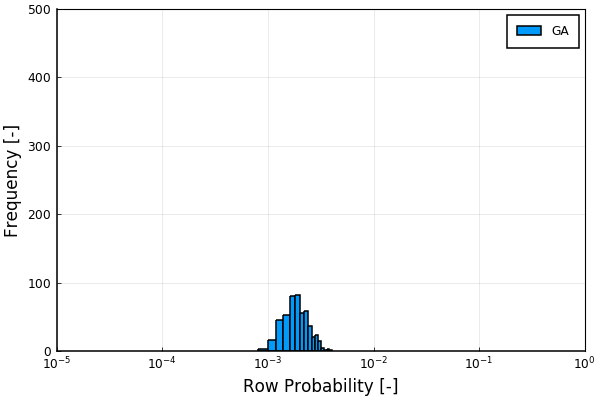

In [11]:
histogram(p_GA, label="GA",
            xscale=:log10, xlims=(1E-5, 1), ylims=(0, 500), thickness_scaling=1.1, box=:on,
            xlabel="Row Probability [-]", ylabel="Frequency [-]")
#png("row_score_dist_ga.png")

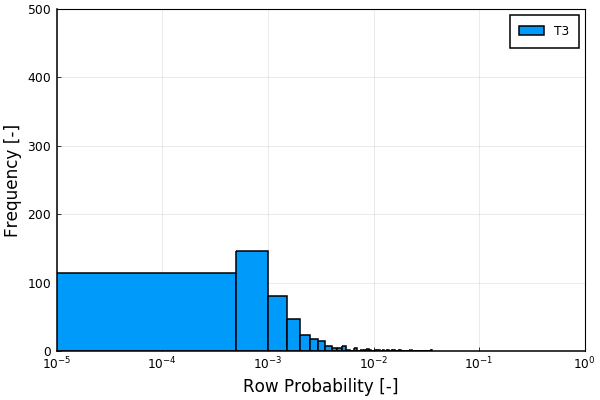

In [12]:
histogram(p_T3, label="T3",
            xscale=:log10, xlims=(1E-5, 1), ylims=(0, 500), thickness_scaling=1.1, box=:on,
            xlabel="Row Probability [-]", ylabel="Frequency [-]")
#png("row_score_dist_t3.png")

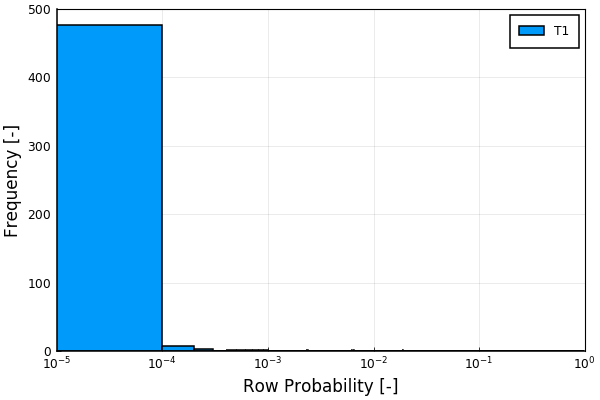

In [13]:
histogram(p_T1, label="T1",
            xscale=:log10, xlims=(1E-5, 1), ylims=(0, 500), thickness_scaling=1.1, box=:on,
            xlabel="Row Probability [-]", ylabel="Frequency [-]")
#png("row_score_dist_t1.png")

In [14]:
function approximate_matrix_multiplication(A, B, dist, m)

    p = probs(dist)

    AB = zeros(size(A)[1], size(B)[2], )

    AB_exact   = A * B
    frob_exact =   norm(AB_exact)
    spec_exact = opnorm(AB_exact)

    frob_error = zeros(m)
    spec_error = zeros(m)

    for i in 1:m

        ik = rand(dist)
        pk = p[ik]

        AB *= i-1
        AB += 1/pk * A[:, ik] * B[ik, :]'
        AB /= i

        frob_error[i] = abs(  norm(AB) - frob_exact) / frob_exact
        spec_error[i] = abs(opnorm(AB) - spec_exact) / spec_exact

    end
    
    return prod, frob_error, spec_error
    
end

approximate_matrix_multiplication (generic function with 1 method)

## Row-norm sampling

In [15]:
AT_GA = transpose(A_GA)
dist_GA = DiscreteNonParametric([i for i in 1:n], p_GA)
m = 10000

ATA_GA, frob_GA, spec_GA = approximate_matrix_multiplication(AT_GA, A_GA, dist_GA, m);

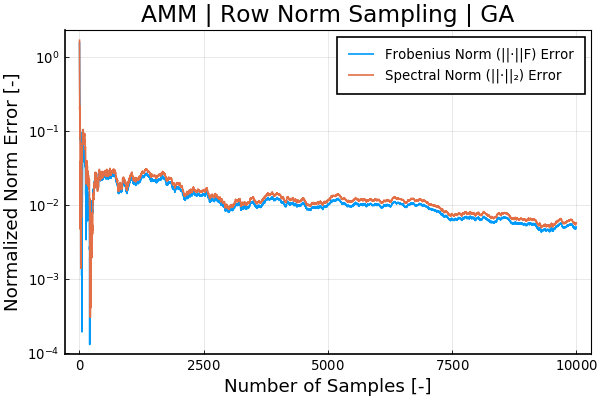

In [16]:
plot( 1:m, frob_GA, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_GA, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Row Norm Sampling | GA")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_row_norm_sampling_ga.png")

In [17]:
AT_T3 = transpose(A_T3)
dist_T3 = DiscreteNonParametric([i for i in 1:n], p_T3)
m = 10000

ATA_T3, frob_T3, spec_T3 = approximate_matrix_multiplication(AT_T3, A_T3, dist_T3, m);

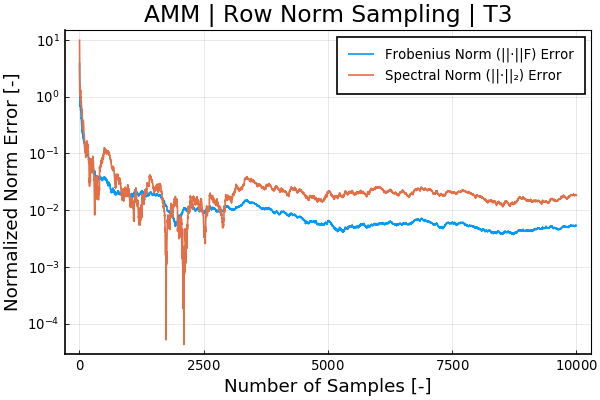

In [18]:
plot( 1:m, frob_T3, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_T3, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Row Norm Sampling | T3")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_row_norm_sampling_t3.png")

In [19]:
AT_T1 = transpose(A_T1)
dist_T1 = DiscreteNonParametric([i for i in 1:n], p_T1)
m = 10000

ATA_T1, frob_T1, spec_T1 = approximate_matrix_multiplication(AT_T1, A_T1, dist_T1, m);

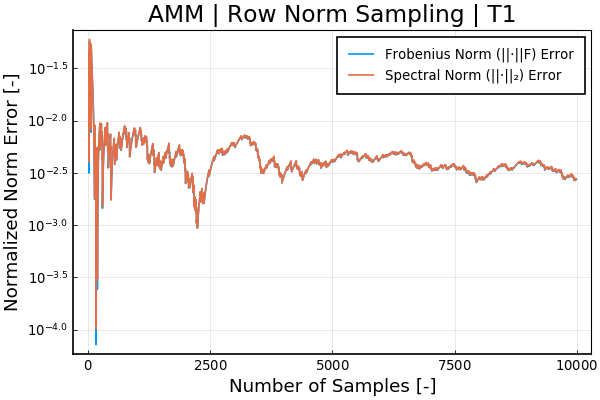

In [20]:
plot( 1:m, frob_T1, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_T1, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Row Norm Sampling | T1")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_row_norm_sampling_t1.png")

## Uniform sampling

In [21]:
uniform_dist = DiscreteNonParametric([i for i in 1:n], [1/n for i in 1:n])

DiscreteNonParametric{Int64,Float64,Array{Int64,1},Array{Float64,1}}(
support: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p: [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002  …  0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
)


In [22]:
ATA_GA, frob_GA, spec_GA = approximate_matrix_multiplication(AT_GA, A_GA, uniform_dist, m);

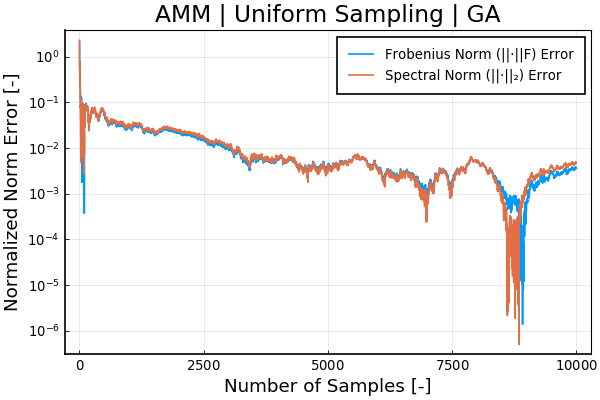

In [23]:
plot( 1:m, frob_GA, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_GA, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Uniform Sampling | GA")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_uniform_sampling_ga.png")

In [24]:
ATA_T3, frob_T3, spec_T3 = approximate_matrix_multiplication(AT_T3, A_T3, uniform_dist, m);

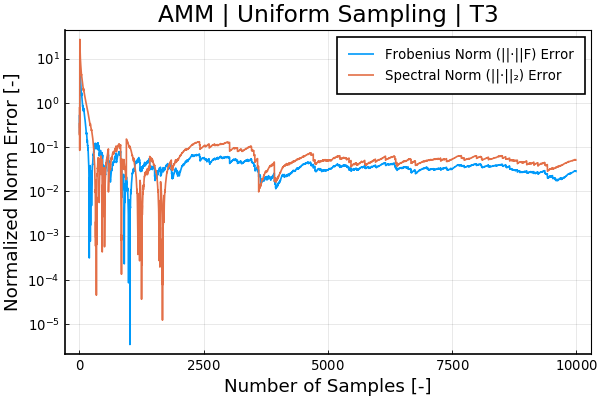

In [25]:
plot( 1:m, frob_T3, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_T3, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Uniform Sampling | T3")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_uniform_sampling_t3.png")

In [26]:
ATA_T1, frob_T1, spec_T1 = approximate_matrix_multiplication(AT_T1, A_T1, uniform_dist, m);

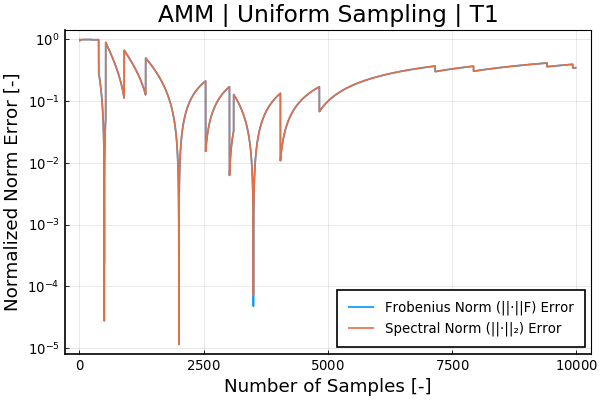

In [27]:
plot( 1:m, frob_T1, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_T1, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Uniform Sampling | T1")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_uniform_sampling_t1.png")

# AMM on MNIST

In [28]:
using MAT

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/Users/rossalexander/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000010943b7ff, Ptr{Nothing} @0x00000001094d71d3, Ptr{Nothing} @0x00000001094d905b, Ptr{Nothing} @0x00000001094d6c5f, Ptr{Nothing} @0x00000001094d6edc, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x00000001094f0dde, Ptr{Nothing} @0x00000001094efed0, Ptr{Nothing} @0x00000001094f05e1, Ptr{Nothing} @0x00000001094f0ce6, Ptr{Nothing} @0x00000001094c9e77, Ptr{Nothing} @0x00000001094f1ced, Ptr{Nothing} @0x000000010e360c73, Ptr{Nothing} @0x0000000134a72a7c, Ptr{Nothing} @0x00000001094d907f, Ptr{Nothing} @0x00000001094d6c5f, Ptr{Nothing} @0x00000001094d6edc, Base.InterpreterIP in top-level CodeInfo for Plots at statement 10, Ptr{Nothing} @0x00000001094f0dde, Ptr{Nothing} @0x00000001094f1b07, Ptr{Nothing}

In [29]:
file = matopen("mnist_matrix.mat")
A_MNIST = read(file, "A")
close(file)

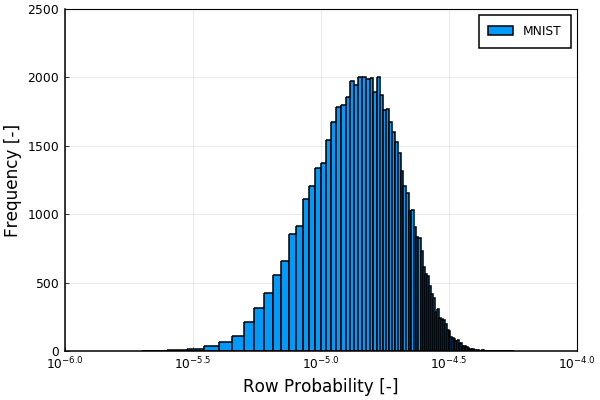

In [30]:
p_MNIST = row_score_probabilities(A_MNIST)

histogram(p_MNIST, label="MNIST",
            xscale=:log10, xlims=(1E-6, 1E-4), ylims=(0, 2500), thickness_scaling=1.1, box=:on,
            xlabel="Row Probability [-]", ylabel="Frequency [-]")
#png("row_score_dist_mnist.png")

In [31]:
AT_MNIST = transpose(A_MNIST)
dist_MNIST = DiscreteNonParametric([i for i in 1:size(A_MNIST)[1]], p_MNIST)
m = 1000

ATA_MNIST, frob_MNIST, spec_MNIST = approximate_matrix_multiplication(AT_MNIST, A_MNIST, dist_MNIST, m);

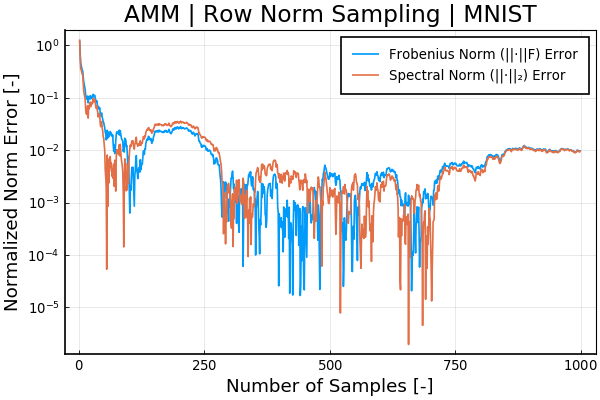

In [32]:
plot( 1:m, frob_MNIST, label="Frobenius Norm (||⋅||F) Error",
        box=:on, thickness_scaling=1.2, yscale=:log10)
plot!(1:m, spec_MNIST, label="Spectral Norm (||⋅||₂) Error")
title!("AMM | Row Norm Sampling | MNIST")
xlabel!("Number of Samples [-]")
ylabel!("Normalized Norm Error [-]")
#png("amm_row_norm_sampling_mnist.png")